In [3]:
import glob
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support


import imblearn as imb
from imblearn.under_sampling import RandomUnderSampler

import scipy


In [4]:
data_2021 = pd.read_csv('../data/img_scout_dfs/2021/smr_vis_skysat_scout_2021.csv')

In [5]:
data_2021.Date.unique()

array(['2021-07-07', '2021-07-27', '2021-08-03', '2021-08-10',
       '2021-08-17'], dtype=object)

In [6]:
#2021
data_2021['DMCast_events'] = 0
data_2021.loc[data_2021['Date'] == '2021-07-07', 'DMCast_events'] = 45
data_2021.loc[data_2021['Date'] == '2021-07-27', 'DMCast_events'] = 78
data_2021.loc[data_2021['Date'] == '2021-08-03', 'DMCast_events'] = 49
data_2021.loc[data_2021['Date'] == '2021-08-10', 'DMCast_events'] = 78
data_2021.loc[data_2021['Date'] == '2021-08-17', 'DMCast_events'] = 74

In [7]:
data_2021['GDM_sev']='low'
data_2021.loc[data_2021['DM_severity'] > 10, 'GDM_sev'] = 'high'
    
data_2021['GDM_inc']='low'
data_2021.loc[data_2021['DM_inc'] > 25, 'GDM_inc'] = 'high'

Low severity: 791
High severity: 404
Proportion: 1.96 : 1


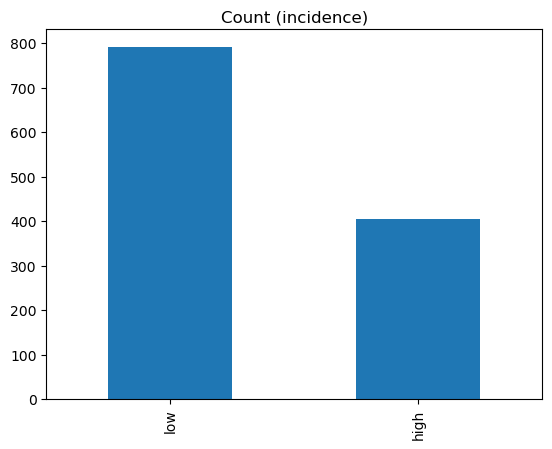

In [9]:
target_count = data_2021.GDM_inc.value_counts()
print('Low severity:', target_count[0])
print('High severity:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (incidence)');

In [10]:
# All high severity panels are clustered on later image dates
# leaving one of these images out will make test set too small

# Better idea: random forest for 2020, report accuracy metrics and kappa score

# Later test global model on hold-out image from 2020

# data_2020[data_2020['GDM_sev']=='high'].Date.unique()

In [11]:
data_2021.columns

Index(['acquired', 'plot', 'blue', 'green', 'red', 'nir', 'veg_smr',
       'savi_exp', 'savi', 'msavi', 'evi', 'arvi', 'gri', 'ndvi', 'nir_blue',
       'nir_green', 'red_blue', 'green_red', 'green_blue', 'row', 'panel',
       'Date', 'Treatment', 'Block', 'PM_severity', 'DM_severity', 'total_dis',
       'geometry', 'centroid', 'PM_inc', 'DM_inc', 'DMCast_events', 'GDM_sev',
       'GDM_inc'],
      dtype='object')

In [12]:
# First with no DMCast
expl_vars = ['blue', 'green', 'red', 'nir','savi', 'evi', 'arvi', 'gri', 'ndvi']
resp_var = 'GDM_sev'

In [13]:
def run_rf_us(df, expl_vars, resp_var, SPLIT_RND_SEED, rand_state):
    X = df[expl_vars]
    y = df[resp_var]
    
    rus = RandomUnderSampler(random_state=2020)
    X_rus, y_rus = rus.fit_resample(X, y)

# Split dataset into training set and test set

    X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus,
                                                    test_size=0.3, 
                                                    random_state=SPLIT_RND_SEED,
                                                    stratify = y_rus)  # 70% training and 30% test
    from sklearn.ensemble import RandomForestClassifier
    # Create a Gaussian Classifier with 500 trees 
    rf = RandomForestClassifier(n_estimators = 500, 
                                oob_score=True, 
                                random_state=rand_state, # random number to be used, needed to reproduce the same result
                                verbose=False)
    
    rf_model = rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score(y_test, y_pred)
    
    from sklearn.metrics import precision_recall_fscore_support
    
    prec, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')
  
    
    from sklearn.metrics import cohen_kappa_score
        
    cohen_score = cohen_kappa_score(y_test, y_pred)    

    
    metrics = {
        'cohen_kappa': [cohen_score], 
        'accuracy_score': [accuracy],
        'precision': [prec],
        'recall': [recall]
    }
    metrics_df = pd.DataFrame(data=metrics)
    
    return metrics_df


In [14]:
import random
 
rand_list=[]
n=100
for i in range(n):
    rand_list.append(random.randint(100,999))

In [16]:
results = []
for r in rand_list:
    res_df = run_rf_us(data_2021, expl_vars, resp_var, r, 2021)
    
    results.append(res_df)

In [17]:
results_df = pd.concat(results)

results_df.mean()


cohen_kappa       0.371880
accuracy_score    0.686027
precision         0.689440
recall            0.686027
dtype: float64

In [19]:
# For incidence
 
rand_list=[]
n=100
for i in range(n):
    rand_list.append(random.randint(100,999))

In [20]:
results_inc = []
for r in rand_list:
    res_df = run_rf_us(data_2021, expl_vars, 'GDM_inc', r, 4040)
    
    results_inc.append(res_df)

In [21]:
results_inc_df = pd.concat(results_inc)

results_inc_df.mean()

cohen_kappa       0.657374
accuracy_score    0.828683
precision         0.830858
recall            0.828683
dtype: float64